In [1]:
from copy import deepcopy

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from neurasort.preprocessing import free_whisking_preprocessing_pipe

In [2]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

from sklearn.inspection import permutation_importance

In [4]:
raw_predictors_free_whisking = pd.read_csv("raw_predictors.csv")
# raw_predictors_free_whisking.drop("Cell_tdTomatoExpressing", axis=1, inplace=True)
preprocessing_pipe = free_whisking_preprocessing_pipe()
class_weights = (1 - raw_predictors_free_whisking["cell_type"].value_counts() / raw_predictors_free_whisking["cell_type"].shape[0]).to_dict()
raw_predictors_free_whisking

,cell_type,firing_rate,ap_threshold,ap_duration,mean_vm,std_vm,fft_low,fft_high,ap_amp_mean,ap_amp_cv,...,ap_upstroke_cv,mean_ap_downstroke,ap_downstroke_cv,isi_mean,isi_cv,irregularity_index,adaptation_index,nb_bursts,mean_burst_dur,burst_dur_cv
0,EXC,3.25,-0.028422,0.563846,-0.038375,0.005196,0.000043,0.000518,-0.018385,-0.088507,...,0.052025,-20.470192,-2.099072e-02,0.198739,1.391880,1.183026,0.531650,3,0.008700,0.090627
1,EXC,0.20,-0.033953,1.012500,-0.049049,0.004335,0.000053,0.000485,0.023787,0.783135,...,0.538352,-76.218750,-1.825080e-01,2.149617,0.655485,1.240803,0.088919,0,0.000000,0.000000
2,EXC,0.05,-0.039291,3.350000,-0.050940,0.005286,0.000063,0.000519,0.018959,0.000000,...,0.000000,-140.937500,-0.000000e+00,50.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000
3,EXC,0.00,0.000000,0.000000,-0.047544,0.004778,0.000057,0.000557,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,50.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000
4,EXC,0.15,-0.033361,1.733333,-0.046490,0.002881,0.000031,0.000403,-0.015417,-0.128832,...,0.057005,-13.062500,-1.359890e-16,6.181850,0.999337,1.998674,1.000664,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,SST,6.60,-0.047992,0.564015,-0.056633,0.003752,0.000066,0.000438,0.000624,1.703971,...,0.070471,-112.085708,-1.050127e-02,0.151526,1.091051,1.042949,1.610850,6,0.007608,0.218271
493,SST,6.80,-0.047427,0.578676,-0.056827,0.004175,0.000071,0.000514,-0.001903,-0.807645,...,0.098239,-102.279870,-4.489533e-02,0.138538,1.181974,1.027054,0.212855,5,0.006750,0.284082
494,SST,7.50,-0.047400,0.589667,-0.056011,0.004038,0.000067,0.000460,-0.004688,-0.153415,...,0.088352,-92.699148,-2.874148e-02,0.133523,1.158016,1.023299,1.700127,7,0.007171,0.233565
495,SST,5.50,-0.048279,0.580455,-0.056918,0.003525,0.000054,0.000430,-0.005145,-0.169298,...,0.074394,-92.506817,-7.912162e-03,0.179331,1.022552,1.029269,0.380484,6,0.005608,0.132077


In [5]:
X = raw_predictors_free_whisking.drop("cell_type", axis=1)
y = raw_predictors_free_whisking["cell_type"]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
 '#7f7f7f', '#bcbd22', '#17becf', "#422d96", "#80186b"]#, "#b54f00"]

In [7]:
gbclf_pipe = deepcopy(preprocessing_pipe)
gbclf_pipe.steps.append(
    ("clf", GradientBoostingClassifier(
            random_state=0, 
            learning_rate=1.0,
            max_depth=2,
            n_estimators=176,
        )
    )
)

lrclf_pipe = deepcopy(preprocessing_pipe)
lrclf_pipe.steps.append(
    ("clf", LogisticRegression(
            random_state=0,
            C=5.241596073257687,
            class_weight=class_weights,
        )
    )
)

rfclf_pipe = deepcopy(preprocessing_pipe)
rfclf_pipe.steps.append(
    ("clf", RandomForestClassifier(
            random_state=0, 
            class_weight=class_weights,
            criterion='log_loss',
            max_depth=9,
            n_estimators=174,
            min_samples_leaf=1
        )
    )
)

svclf_pipe = deepcopy(preprocessing_pipe)
svclf_pipe.steps.append(
    ("clf", LinearSVC(
            random_state=0,
            C=0.8428426081680506,
            class_weight=class_weights,
            multi_class='crammer_singer',
        )
    )
)



In [36]:
import warnings
warnings.filterwarnings('ignore')

model_names = ["Gradient Boosting", "Logistic Regression", "Random Forest", "Linear Support Vector Machine"]
models = [gbclf_pipe, lrclf_pipe, rfclf_pipe, svclf_pipe]
for model_name, model in zip(model_names, models):
    scores = cross_val_score(
        estimator=model,
        X=X,
        y=y,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
        scoring="f1_weighted"
    )
    print(f"{model_name}: mean = {scores.mean()}, std = {scores.std()}")
    
warnings.filterwarnings('default')

Gradient Boosting: mean = 0.8888314734735434, std = 0.03658409822713893
Logistic Regression: mean = 0.8755727580879858, std = 0.018767240561896742
Random Forest: mean = 0.8788913029534399, std = 0.03340115366622616
Linear Support Vector Machine: mean = 0.8832143502399499, std = 0.00896341583287301


In [37]:
model_names = ["Gradient\nBoosting", "Linear Support\nVector Machine", "Random\nForest", "Logistic\nRegression"]
models = [gbclf_pipe, svclf_pipe, rfclf_pipe, lrclf_pipe]

preds = []
warnings.filterwarnings('ignore')
for model_name, model in zip(model_names, models):
    pred = cross_val_predict(
        estimator=model,
        X=X,
        y=y,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
    )
    preds.append(pred)
warnings.filterwarnings('default')

In [38]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [39]:
len(preds)

4

/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_8229/1123112896.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cfs_mat.diagonal()/cfs_mat.sum(axis=1), ax=ax, palette='colorblind')
/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_8229/1123112896.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.unique(y))
/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_8229/1123112896.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cfs_mat.diagonal()/cfs_mat.sum(axis=1), ax=ax, palette='colorblind')
/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/

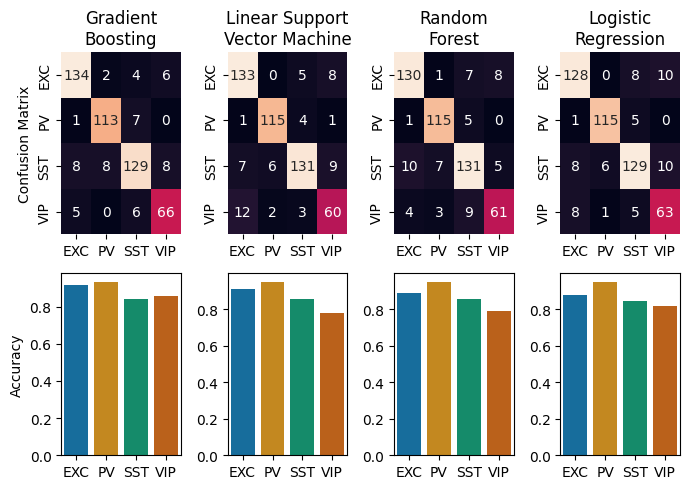

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(7, 5))
for i, ax in enumerate(axes.flatten()):
    
    if i <= 3:
        cfs_mat = confusion_matrix(y, preds[i])
        sns.heatmap(cfs_mat, annot=True, fmt='g', ax=ax, cbar=False)
        ax.set_xticklabels(np.unique(y))
        ax.set_yticklabels(np.unique(y))
        ax.set_title(f"{model_names[i]}")
        if i ==0:
            ax.set_ylabel("Confusion Matrix")
    else:
        cfs_mat = confusion_matrix(y, preds[i-4])
        sns.barplot(data=cfs_mat.diagonal()/cfs_mat.sum(axis=1), ax=ax, palette='colorblind') 
        ax.set_xticklabels(np.unique(y))
        if i == 4:
            ax.set_ylabel("Accuracy")
          
    
plt.tight_layout()

In [29]:
confusion_matrix(y, preds[1], labels=np.unique(y))

array([[128,   0,   8,  10],
       [  1, 115,   5,   0],
       [  8,   6, 129,  10],
       [  8,   1,   5,  63]])

In [30]:
confusion_matrix(y, preds[2])

array([[130,   1,   7,   8],
       [  1, 115,   5,   0],
       [ 10,   7, 131,   5],
       [  4,   3,   9,  61]])

# 1.1 Gradient Boosting

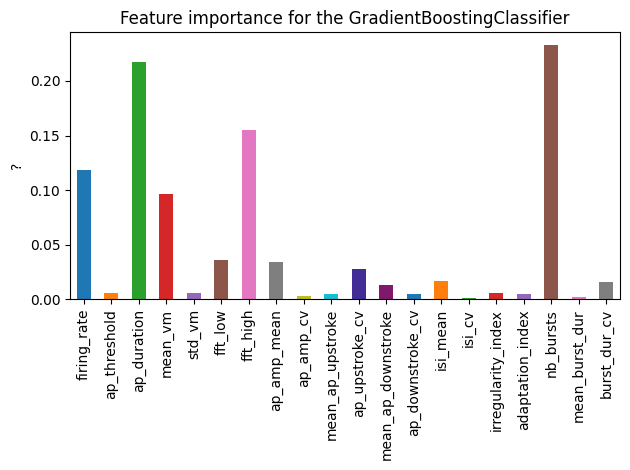

In [31]:
gbclf_pipe.fit(X, y)
fig, ax = plt.subplots()

gb_impotances = pd.Series(gbclf_pipe.named_steps.clf.feature_importances_, index=gbclf_pipe.named_steps.clf.feature_names_in_)
gb_impotances.plot.bar(ax=ax, color=colors)
ax.set_title(f"Feature importance for the GradientBoostingClassifier")
ax.set_ylabel("Feature ")
fig.tight_layout()
plt.show()
plt.show()

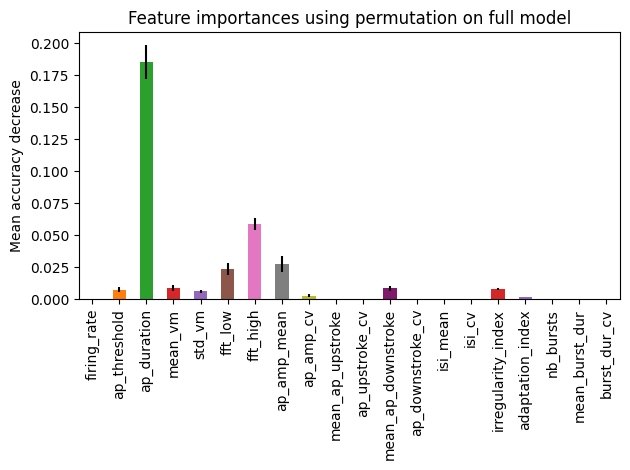

In [46]:
result = permutation_importance(
    gbclf_pipe.named_steps.clf, preprocessing_pipe.fit_transform(X), y, n_repeats=10, random_state=42, n_jobs=2, sample_weight=raw_predictors_free_whisking["cell_type"].apply(lambda x : class_weights[x])
)
gb_importances = pd.Series(result.importances_mean, index=gbclf_pipe.named_steps.clf.feature_names_in_)
fig, ax = plt.subplots()
gb_importances.plot.bar(yerr=result.importances_std, ax=ax, color=colors)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# 1.2 SVM

https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn

/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


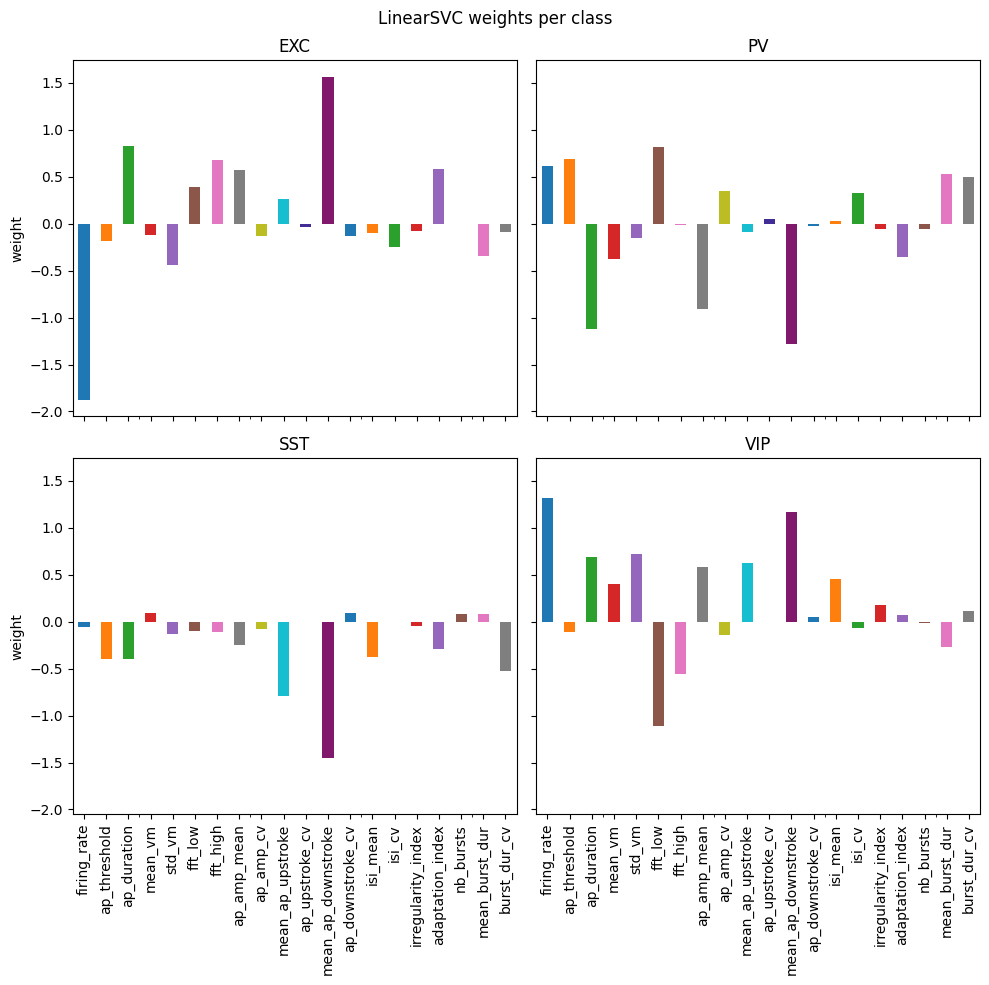

In [63]:
svclf_pipe.fit(X, y)
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    svm_impotances = pd.Series(svclf_pipe.named_steps.clf.coef_[i], index=svclf_pipe.named_steps.clf.feature_names_in_)
    svm_impotances.plot.bar(ax=ax, color=colors)
    ax.set_title(f"{svclf_pipe.named_steps.clf.classes_[i]}")
    ax.set_ylabel("weight")
    # for i in ax.containers:
    #     ax.bar_label(
    #         i,
    #     )
fig.suptitle("LinearSVC weights per class")
fig.tight_layout()
plt.show()
plt.show()

/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


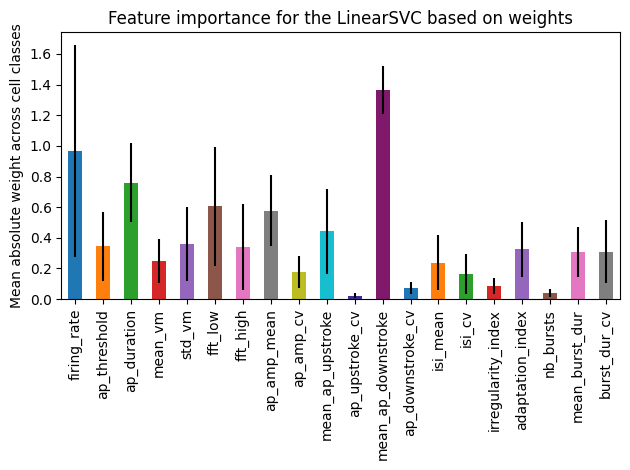

In [33]:
svclf_pipe.fit(X, y)
fig, ax = plt.subplots()

svm_impotances = pd.Series(np.mean(np.abs(svclf_pipe.named_steps.clf.coef_), axis=0), index=svclf_pipe.named_steps.clf.feature_names_in_)
std = np.std(np.abs(svclf_pipe.named_steps.clf.coef_), axis=0)
svm_impotances.plot.bar(ax=ax, color=colors, yerr=std)
ax.set_title(f"Feature importance for the LinearSVC based on weights")
ax.set_ylabel("Mean absolute weight across cell classes")
fig.tight_layout()
plt.show()
plt.show()

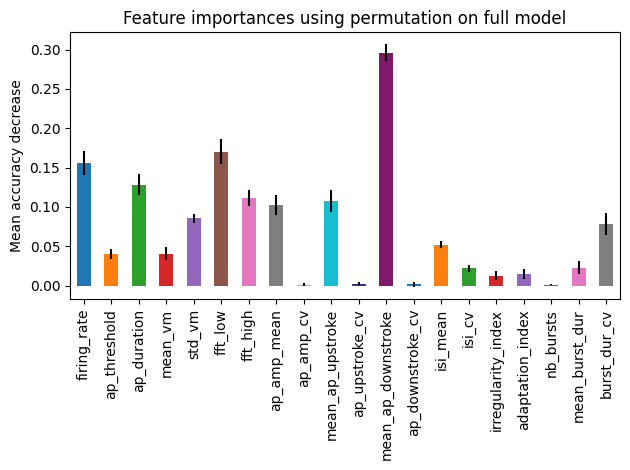

In [44]:
result = permutation_importance(
    svclf_pipe.named_steps.clf, preprocessing_pipe.fit_transform(X), y, n_repeats=10, random_state=42, n_jobs=2, sample_weight=raw_predictors_free_whisking["cell_type"].apply(lambda x : class_weights[x])
)
lsvc_importances = pd.Series(result.importances_mean, index=svclf_pipe.named_steps.clf.feature_names_in_)
fig, ax = plt.subplots()
lsvc_importances.plot.bar(yerr=result.importances_std, ax=ax, color=colors)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# 1.3 Random Forest

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

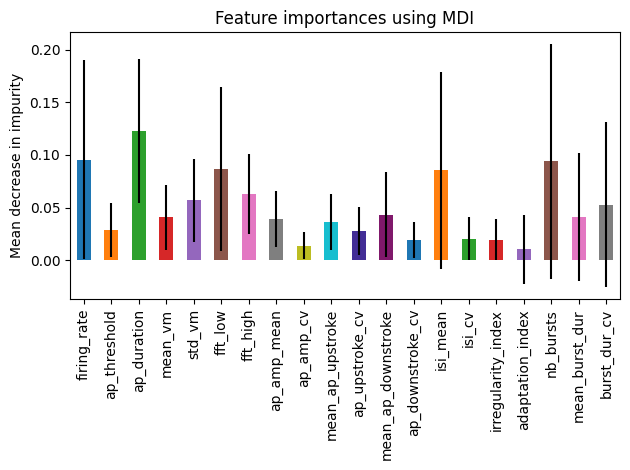

In [42]:
rfclf_pipe.fit(X, y)
importances = rfclf_pipe.named_steps.clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfclf_pipe.named_steps.clf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=rfclf_pipe.named_steps.clf.feature_names_in_)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax, color=colors)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

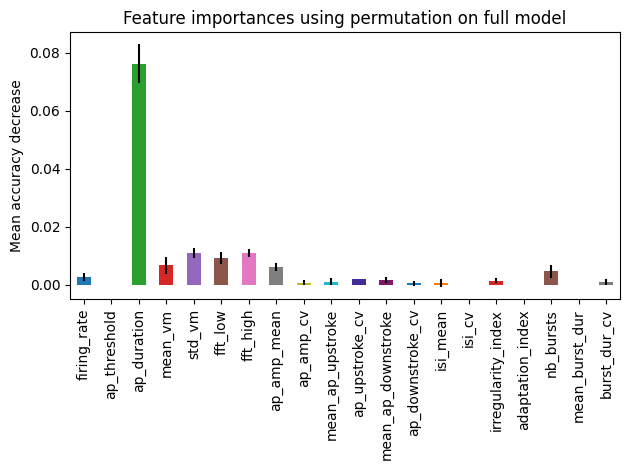

In [43]:
result = permutation_importance(
    rfclf_pipe.named_steps.clf, preprocessing_pipe.fit_transform(X), y, n_repeats=10, random_state=42, n_jobs=2, sample_weight=raw_predictors_free_whisking["cell_type"].apply(lambda x : class_weights[x])
)
forest_importances = pd.Series(result.importances_mean, index=rfclf_pipe.named_steps.clf.feature_names_in_)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax, color=colors)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# 1.4 Logistic Regression

In [47]:
lrclf_pipe.fit(X, y)

/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('scaling', StandardScaler()),
                ('remove_constants', VarianceThreshold()),
                ('clf',
                 LogisticRegression(C=5.241596073257687,
                                    class_weight={'EXC': 0.7062374245472838,
                                                  'PV': 0.7565392354124748,
                                                  'SST': 0.6921529175050302,
                                                  'VIP': 0.8450704225352113},
                                    random_state=0))])

In [54]:
lrclf_pipe.named_steps.clf.coef_.shape

(4, 20)

/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


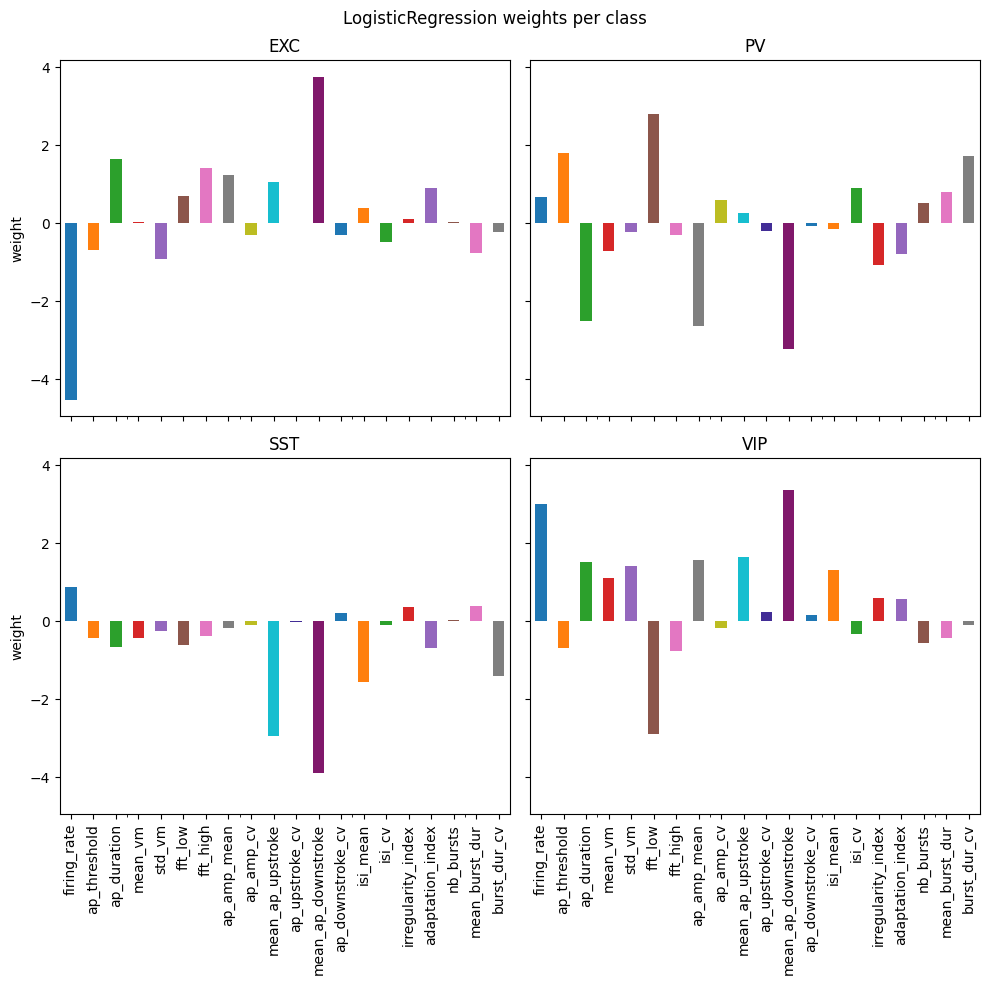

In [62]:
lrclf_pipe.fit(X, y)
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    lr_impotances = pd.Series(lrclf_pipe.named_steps.clf.coef_[i], index=lrclf_pipe.named_steps.clf.feature_names_in_)
    lr_impotances.plot.bar(ax=ax, color=colors)
    ax.set_title(f"{lrclf_pipe.named_steps.clf.classes_[i]}")
    ax.set_ylabel("weight")
    # for i in ax.containers:
    #     ax.bar_label(
    #         i,
    #     )
fig.suptitle("LogisticRegression weights per class")
fig.tight_layout()
plt.show()
plt.show()